In [1]:
### default
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### modeling
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

### visualization
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# 센서 종류
sensors = ['C7H8', 'TMA', 'VOC', 'CO2', 'HCHO', 'H2S', 'NH3', 'CH3SH', 'SO2', 'NO2', 'CO']
cols = ['C7H8', 'TMA', 'VOC', 'CO2', 'HCHO', 'H2S', 'NH3', 'CH3SH', 'SO2', 'NO2', 'CO', 'reg_date', 'label_type']

In [3]:
df = pd.read_csv('df_type_total.csv') # 3,4차 데이터셋

In [4]:
df = df[cols]

In [5]:
# 데이터셋을 만들기 위한 실험 구분
df['lagged'] = df['reg_date'].shift(-1)
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['lagged'] = pd.to_datetime(df['lagged'])
df['diff'] = df['lagged'] - df['reg_date']
df['diff'] = df['diff'] /  pd.Timedelta('1s')
df['diff'].fillna(1,inplace=True) #마지막줄 채워주기 위함
df.reset_index(drop=True, inplace=True)

In [6]:
num = 0
for i in range(len(df)):
    if df.loc[i,'diff'] in [1,2]:
        df.loc[i,'exp_num'] = num
    else:
        df.loc[i,'exp_num'] = num
        num+=1

<AxesSubplot:>

findfont: Font family ['NanumGothinc'] not found. Falling back to DejaVu Sans.


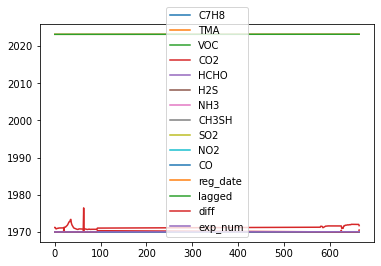

In [7]:
df[df['label_type']=='B'].plot() # 중간 부분은 다른 종류 실험 있던 부분

<AxesSubplot:>

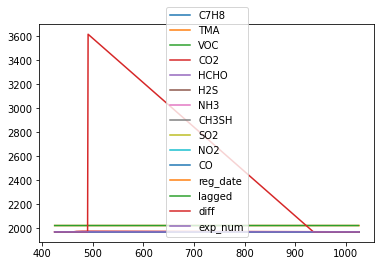

In [8]:
df[df['label_type']=='C'].plot()

In [9]:
X = []
y = []
def create_windows(df, window_size=5):
    for num, group_df in df.groupby('exp_num'):
        data = group_df.iloc[:, 0:11].values
        labels = group_df['label_type'].values
        for i in range(len(data) - window_size + 1):
            X.append(data[i:i+window_size])
            y.append(labels[window_size-1])
    return np.array(X), np.array(y)

window_size=5
X, y= create_windows(df, window_size)
# y = df['label_type'].values[window_size-1:]

In [10]:
X.shape, y.shape

((919, 5, 11), (919,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

y_train = to_categorical(y_train, num_classes=len(np.unique(y)))
y_test = to_categorical(y_test, num_classes=len(np.unique(y)))

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[-1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 32)             1088      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1650      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306       
Total params: 3,044
Trainable params: 3,044
Non-trainable params: 0
______________________________________________________

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Step 5: Train and evaluate the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
23/23 - 1s - loss: 1.7067 - accuracy: 0.2694 - val_loss: 1.4490 - val_accuracy: 0.4185
Epoch 2/100
23/23 - 0s - loss: 1.4487 - accuracy: 0.4340 - val_loss: 1.2679 - val_accuracy: 0.5815
Epoch 3/100
23/23 - 0s - loss: 1.3000 - accuracy: 0.5116 - val_loss: 1.1320 - val_accuracy: 0.6304
Epoch 4/100
23/23 - 0s - loss: 1.1787 - accuracy: 0.5755 - val_loss: 1.0115 - val_accuracy: 0.6793
Epoch 5/100
23/23 - 0s - loss: 1.0695 - accuracy: 0.6109 - val_loss: 0.9126 - val_accuracy: 0.7120
Epoch 6/100
23/23 - 0s - loss: 0.9486 - accuracy: 0.6558 - val_loss: 0.8173 - val_accuracy: 0.7554
Epoch 7/100
23/23 - 0s - loss: 0.8782 - accuracy: 0.6803 - val_loss: 0.7401 - val_accuracy: 0.7935
Epoch 8/100
23/23 - 0s - loss: 0.8045 - accuracy: 0.7129 - val_loss: 0.6822 - val_accuracy: 0.8315
Epoch 9/100
23/23 - 0s - loss: 0.7255 - accuracy: 0.7633 - val_loss: 0.6279 - val_accuracy: 0.8261
Epoch 10/100
23/23 - 0s - loss: 0.6813 - accuracy: 0.7497 - val_loss: 0.5970 - val_accuracy: 0.8370
Epoch 11/

findfont: Font family ['NanumGothinc'] not found. Falling back to DejaVu Sans.


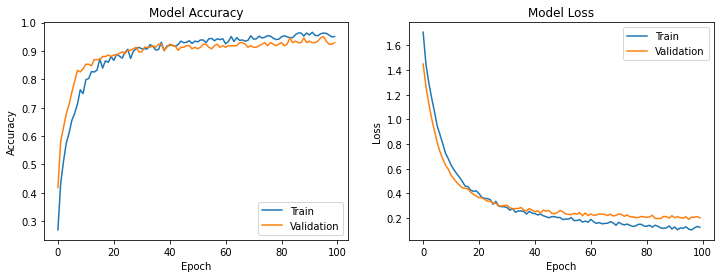

In [15]:
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')

    plt.show()

plot_metrics(history)

In [16]:
max(history.history['accuracy'])

0.9659863710403442